# Proximity draft

In the cell below, the notebook introduces a preliminary implementation of the proximity metric from Gustafson and Parker (1992) [1]. We use the `class_src` and `class_dst` arguments to select the source and destination classes, i.e., we compute the proximity of patches of the source class to patches of the destination class.

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swisslandstats as sls
from scipy import ndimage

import pylandstats as pls


def proximity_index(ls, class_src, class_dst, search_radius):
    """
    Proximity index.

    Parameters
    ----------
    ls : pylandstats.Landscape
        The landscape instance used to compute the metric.
    class_src, class_dst : int, optional
        Source and destination classes (respectively) used to compute the metric.
    search_radius : numeric
        Search radius defining the neighborhood at which the metric will be computed for
        each patch.

    Returns
    -------
    PROX : numeric
        PROX >= 0 ; prox equals 0 if a patch has no neighbors, and increases as the
        neighborhood is occupied by patches of the same type and those patches become
        more contiguous (or less fragmented).
    """
    # first of all, we get some iteration-independent variables that will be useful in
    # the loop below
    num_buffer_cells = int(search_radius / ls.cell_width)
    num_rows, num_cols = ls.landscape_arr.shape
    # then, we get the label arrays for the source and destination classes
    src_label_arr, dst_label_arr = [
        ls.class_label(class_val)[0] for class_val in [class_src, class_dst]
    ]
    # the slices that correspond to each patch of the source class
    patch_slices = ndimage.find_objects(src_label_arr)
    # and init an empty array for the computed indices
    proximity = np.empty(len(patch_slices))

    # we now iterate the patches of the source class
    for patch_label, (patch_row_slice, patch_col_slice) in enumerate(
        patch_slices, start=1
    ):
        # we now identify the slice region that corresponds to the focus patch plus the
        # search buffer
        _slice = np.s_[
            max(0, patch_row_slice.start - num_buffer_cells) : min(
                patch_row_slice.stop + num_buffer_cells, num_rows
            ),
            max(0, patch_col_slice.start - num_buffer_cells) : min(
                patch_col_slice.stop + num_buffer_cells, num_cols
            ),
        ]
        # and get a boolean array corresponds to the target patch (True) plus the search
        # buffer
        patch_arr = src_label_arr[_slice] == patch_label
        # let us now get the labels of the patches of the destination class, and drop
        # the 0 (in class label arrays, 0 always corresponds to pixels that are not of
        # that class)
        neighbor_patches_arr = dst_label_arr[_slice]
        neighbor_labels = np.unique(neighbor_patches_arr)
        neighbor_labels = neighbor_labels[neighbor_labels != 0]

        # we can get the areas of the neighbor patches using the patch labels (note that
        # patch labels start at 1 whereas pandas series indexing starts at 0)
        neighbor_areas = ls.area(class_val=class_dst).iloc[neighbor_labels - 1]

        # to get the distances to the neighbor patches, we will generate another label
        # array where the focus patch is labeled as 1 and the others are labeled from 2
        # to the number of neighbor patches plus one (since we start indexing at 2 to
        # distinguish from the focus path - labeled as 1)
        _label_arr = neighbor_patches_arr.copy()
        for new_label, neighbor_label in enumerate(neighbor_labels, start=2):
            _label_arr[neighbor_patches_arr == neighbor_label] = new_label
        _label_arr += np.where(patch_arr, 1, 0)
        # note that `compute_patch_euclidean_nearest_neighbor` computes the distances
        # for all patches in `_label_arr`, which includes the focus patch, which is not
        # considered to compute proximity (and hence dropped from the returned array via
        # slicing)
        try:
            enn = ls.compute_patch_euclidean_nearest_neighbor(_label_arr)[1:]
            # the proximity index for the focus patch can now very easily be computed as
            # follows (note that patch labels start at 1 whereas numpy array indexing
            # starts at 0)):
            patch_proximity = np.sum(neighbor_areas / enn)
        except IndexError:
            # in some cases, we can have a patch of the source class adjacent to a patch
            # of the destination class, which results in an ENN of 0, hence we cannot
            # divide by it.
            warnings.warn(
                f"Patch {patch_label} of the source class is adjacent to a patch of the"
                " destination class. Returning nan to avoid division by zero.",
                RuntimeWarning,
            )
            patch_proximity = np.nan
        proximity[patch_label - 1] = patch_proximity

    return proximity

We first need to run the cell below so that the land use/land cover (LULC) data is downloaded and preprocessed (see [A03-swisslandstats-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/A03-swisslandstats-preprocessing.ipynb) for more details).

In [ ]:
!make -C .. lulc_rasters

make: Entering directory '/home/martibosch/data-science/pylandstats-notebooks'
make: Nothing to be done for 'lulc_rasters'.
make: Leaving directory '/home/martibosch/data-science/pylandstats-notebooks'


This is what the landscape used in this example looks like:

<AxesSubplot:>

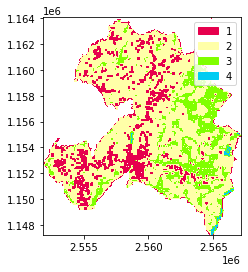

In [ ]:
input_filepath = "../data/processed/veveyse-AS18_4.tif"

ls = pls.Landscape(input_filepath)
ls.plot_landscape(cmap=sls.noas04_4_cmap, norm=sls.noas04_4_norm, legend=True)

In this example, the source and destination classes will be "urban" and "forest" respectively, i.e., for each urban patch, we will compute its proximity index to forest patches. To compute the metric, we will use a search radius of 1000 meters.

In [ ]:
class_src = 1  # urban
class_dst = 3  # forest
search_radius = 1000

patch_proximities = proximity_index(ls, class_src, class_dst, search_radius)

/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 120 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 123 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 131 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 164 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 170 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: R

/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 242 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 247 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 248 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 257 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: RuntimeWarning: Patch 274 of the source class is adjacent to a patch of the destination class. Returning nan to avoid division by zero.
  warnings.warn(
/tmp/ipykernel_26714/3796027500.py:96: R

We can build a data frame of patch-level metrics in order to map the computed proximities to the actual patches:

In [ ]:
patch_df = pd.DataFrame(ls.area(class_val=class_src))
patch_df["proximity"] = patch_proximities
patch_df

,area,proximity
0,1.0,0.267514
1,1.0,0.286099
2,1.0,0.337302
3,1.0,0.540459
4,1.0,0.804110
...,...,...
282,6.0,1.663668
283,1.0,15.831384
284,2.0,0.642959
285,1.0,0.806677


We can also plot each patch of the source class (i.e., urban) colored according to its proximity to the destination class (i.e., forest):

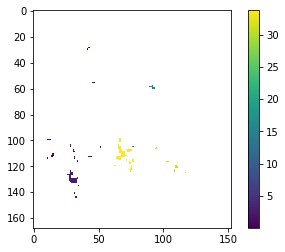

In [ ]:
label_arr = ls.class_label(class_src)[0]
prox_arr = np.full_like(label_arr, np.nan, dtype=patch_proximities.dtype)
# map proximity values to each patch
for patch_label, patch_prox in enumerate(patch_proximities, start=1):
    prox_arr[label_arr == patch_label] = patch_prox

plt.imshow(prox_arr)
plt.colorbar()

## References

1. Gustafson, E. J., & Parker, G. R. (1994). Using an index of habitat patch proximity for landscape design. Landscape and urban planning, 29(2-3), 117-130.